# Consolidate Adsorption Results
Summarize the adsorption energy by composition, surface type, and bond position

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase.io import read
import pandas as pd
import numpy as np
import json

Configuration

In [6]:
width: int = 2  # Number of repeat units in slab directions

In [7]:
co2_energy = json.loads(Path('co2-molecule/co2.json').read_text())['energy']

## Load the Surface Data
Find the relaxed structures 

In [8]:
adsorbates = []
for relaxed_path in Path('adsorbate/').rglob(f'width-{width}/*/relaxed.extxyz'):
    # Start with a summary based on the path
    _, cell_dir, term, _, site, _ = relaxed_path.parts
    comp = cell_dir.split("_")[0]  # Bulk composition
    term = int(term.split("=")[1])
    record = {
        'comp': comp,
        'term': term,
        'site': site,
    }

    # Get the composition of the surface
    relaxed = read(relaxed_path)
    top_layer_z = relaxed.positions[:-3, :].max()  # highest point without the CO2
    top_layer = relaxed[relaxed.positions[:, 2] > top_layer_z - 1.][:-3]
    record['surface_comp'] = top_layer.get_chemical_formula('metal', empirical=True)

    # Get the identity of the atom being bonded to
    start_data = json.loads((relaxed_path.parent / 'metadata.json').read_text())
    record['site_atom'] = start_data['bond_atom']

    # Get the adsorption energy
    relaxed_eng = relaxed.get_potential_energy()
    record['adsorption_energy'] = relaxed_eng - start_data['expected_eng']

    adsorbates.append(record)
adsorbates = pd.DataFrame(adsorbates)
print(f'Completed {len(adsorbates)} adsorption calculations')

Completed 218 adsorption calculations


In [9]:
adsorbates.head()

,comp,term,site,surface_comp,site_atom,adsorption_energy
0,YbWO3,1,mono_metal,WO2,W,0.147383
1,YbWO3,1,pi_metal,WO2,W,-0.330930
2,YbWO3,1,pi_oxygen,WO2,W,-0.334093
3,YbWO3,1,mono_oxygen,WO2,O,0.610603
4,YbWO3,0,mono_metal,YbO,Yb,0.741695


## Compare Energies by Configuration
Find out if running all the configurations is necessary to find one which bonds

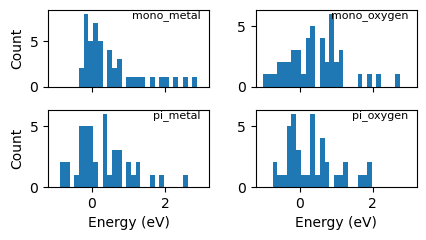

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(4.5, 2.5), sharex=True)

bins = np.linspace(
    np.floor(np.percentile(adsorbates['adsorption_energy'], 10)),
    np.ceil(np.percentile(adsorbates['adsorption_energy'], 90)),
    32
)
for (gid, group), ax in zip(adsorbates.groupby('site'), axs.flatten()):
    ax.text(0.95, 0.9, gid, transform=ax.transAxes, ha='right', fontsize=8)

    ax.hist(group['adsorption_energy'], bins=bins)

for ax in axs[:, 0]:
    ax.set_ylabel('Count')
for ax in axs[-1, :]:
    ax.set_xlabel('Energy (eV)')

fig.tight_layout()